In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import gzip
import matplotlib
import matplotlib.pyplot as plt
import struct as st

In [2]:
def fetch_mnist_data(data):
    '''
    Function that convert mnist gz file to numpy array.
    Param: data: Can be: 'Train', 'Train_labels', 'Test', 'Test_labels'
    Return: numpy array with data from file.
    '''
    
    filenames = {'Train':'train-images-idx3-ubyte.gz', 'Train_labels': 'train-labels-idx1-ubyte.gz',
                'Test': 't10k-images-idx3-ubyte.gz', 'Test_labels': 't10k-labels-idx1-ubyte.gz'}
    
    if data == 'Train' or data == 'Test':
        Data = gzip.open(filenames[data])
        Data.seek(0)
        magic = st.unpack('>I',Data.read(4))[0] # magic number
        quantity = st.unpack('>I',Data.read(4))[0] # number of items
        nR = st.unpack('>I',Data.read(4))[0] # rows
        nC = st.unpack('>I',Data.read(4))[0] # cols
        total = quantity * nR * nC

        Img_data = np.array(st.unpack(f'>{total}B', Data.read(total))).reshape((quantity, nR*nC))
        return Img_data
    
    elif data == 'Train_labels' or data == 'Test_labels':
        Data = gzip.open(filenames[data])
        Data.seek(0)
        magic = st.unpack('>I',Data.read(4))[0] # magic number
        quantity = st.unpack('>I',Data.read(4))[0] # number of items
        
        Img_labels = np.array(st.unpack(f'>{quantity}B', Data.read(quantity)))
        return Img_labels
    
    else:
        raise ValueError("Wrong data")

In [3]:
Train = fetch_mnist_data('Train')
Train_labels = fetch_mnist_data('Train_labels')
Test = fetch_mnist_data('Test')
Test_labels = fetch_mnist_data('Test_labels')

#Shuffle data
shuffle_index = np.random.permutation(60000)
Train, Train_labels = Train[shuffle_index], Train_labels[shuffle_index]

In [4]:
digit = Train[36000].reshape(28,28)

Expected value: 9


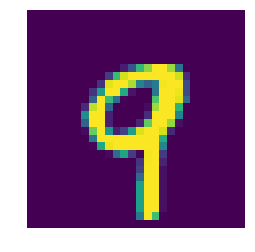

In [5]:
print(f'Expected value: {Train_labels[36000]}')
plt.imshow(digit)
plt.axis('off')
plt.show()

In [6]:
from sklearn.linear_model.stochastic_gradient import SGDClassifier

In [7]:
train_labels_digit = Train_labels == Train_labels[36000]
sgd = SGDClassifier()
sgd.fit(Train, train_labels_digit)
sgd.predict([Train[36000]])

array([False], dtype=bool)

In [8]:
z = sgd.predict(Test)
actual = Test_labels == Train_labels[36000]
np.sum(z == actual) / len(z)

0.94010000000000005

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, Train, train_labels_digit, cv = 3, scoring = 'accuracy')

array([ 0.92935,  0.9476 ,  0.9532 ])

In [10]:
#Implementation of cross valid score

from sklearn.model_selection import StratifiedKFold

def Cross_valid_score(Train, train_labels_digit):
    skfolds = StratifiedKFold(n_splits= 3)
    scores = []
    for train_index, test_index in skfolds.split(Train, train_labels_digit):
        train_folds = Train[train_index]
        train_labels_folds = train_labels_digit[train_index]

        test_folds = Train[test_index]
        test_labels_folds = train_labels_digit[test_index]

        sgd.fit(train_folds, train_labels_folds)
        predict = sgd.predict(test_folds)
        scores.append(np.sum(predict == test_labels_folds) / len(predict))
    return np.array(scores)

Cross_valid_score(Train, train_labels_digit)

array([ 0.95285,  0.9451 ,  0.9479 ])

In [11]:
from sklearn.model_selection import cross_val_predict

train_predict = cross_val_predict(sgd, Train, train_labels_digit, cv = 3)

In [12]:
train_predict

array([ True, False, False, ..., False, False, False], dtype=bool)

In [13]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(train_labels_digit, train_predict)
PN = conf_matrix[0][0] # Prawdziwe negatywne
FP = conf_matrix[0][1] # Fałszywe pozytywne
FN = conf_matrix[1][0] # Fałszywe Negatywne
PP = conf_matrix[1][1] # Prawdziwe Pozytywne

Precision = PP / (PP + FP) # Precyzja klasyfikatora
Recall = PP / (PP + FN) # Pełność klasyfikatora
F1_score = 2*(Precision*Recall / (Precision + Recall))
print(f'Precision: {Precision}')
print(f'Recall: {Recall}')
print(f'F1 score: {F1_score}')

Precision: 0.6603805354436774
Recall: 0.6592704656244747
F1 score: 0.6598250336473754


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(train_labels_digit, train_predict))
print(recall_score(train_labels_digit, train_predict))
print(f1_score(train_labels_digit, train_predict))

0.660380535444
0.659270465624
0.659825033647


In [15]:
y_scores = cross_val_predict(sgd, Train, train_labels_digit, cv=3, method = 'decision_function')
y_scores

array([ 120827.68755874, -428973.05771858, -231781.52940252, ...,
       -330698.71477038, -148361.29020608,   62870.15870661])

In [16]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(train_labels_digit, y_scores)

In [17]:
def precision_recall_threholds(precisions, recalls, threholds):
    plt.plot(thresholds, precisions[:-1], 'r--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], label = 'Recall')
    plt.xlabel("Threshold")
    plt.legend(loc = 'center left')
    plt.show()

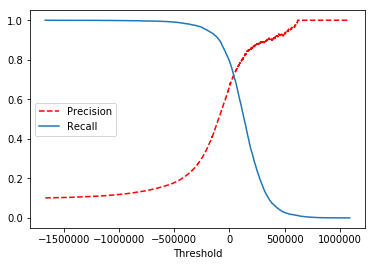

In [18]:
precision_recall_threholds(precisions, recalls, thresholds)

In [19]:
def precision_recall_plot(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

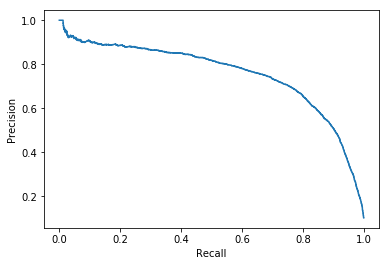

In [20]:
precision_recall_plot(precisions, recalls)

In [21]:
#ROC plot
from sklearn.metrics import roc_curve
rPP, rFP, thresholds = roc_curve(train_labels_digit, y_scores)

In [22]:
def ROC_curve(rPP, rFP):
    plt.plot(rPP, rFP)
    plt.xlabel("Prawdziwie Pozytywne")
    plt.ylabel("Fałszywie Pozytywne")
    plt.show()

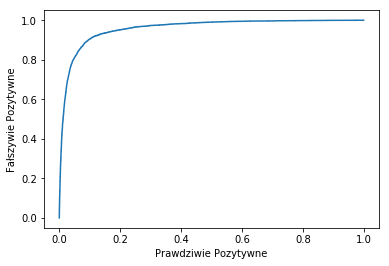

In [23]:
ROC_curve(rPP, rFP)

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=42)
probas_forest = cross_val_predict(forest, Train, train_labels_digit, cv = 3, method = 'predict_proba')

In [25]:
frPP, frFP, thresholds = roc_curve(train_labels_digit, probas_forest[:,1])

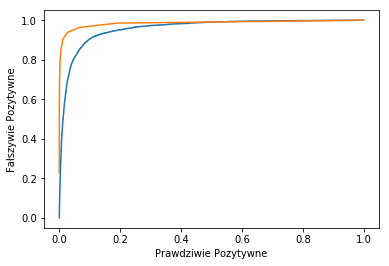

In [26]:
plt.plot(rPP, rFP)
plt.plot(frPP, frFP)
plt.xlabel("Prawdziwie Pozytywne")
plt.ylabel("Fałszywie Pozytywne")
plt.show()

In [27]:
sgd.fit(Train, Train_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [28]:
sgd.predict([Train[36000]])

array([9])

In [29]:
some_digits_score = sgd.decision_function([Train[36000]])

In [30]:
some_digits_score

array([[-846075.29738971, -590686.91368807, -487941.05072658,
        -651660.71678664, -245204.75674866, -473707.91958788,
        -421317.04697892, -107898.77277594, -157598.24001032,
           6592.44959611]])

In [36]:
sgd.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])